<center><img src='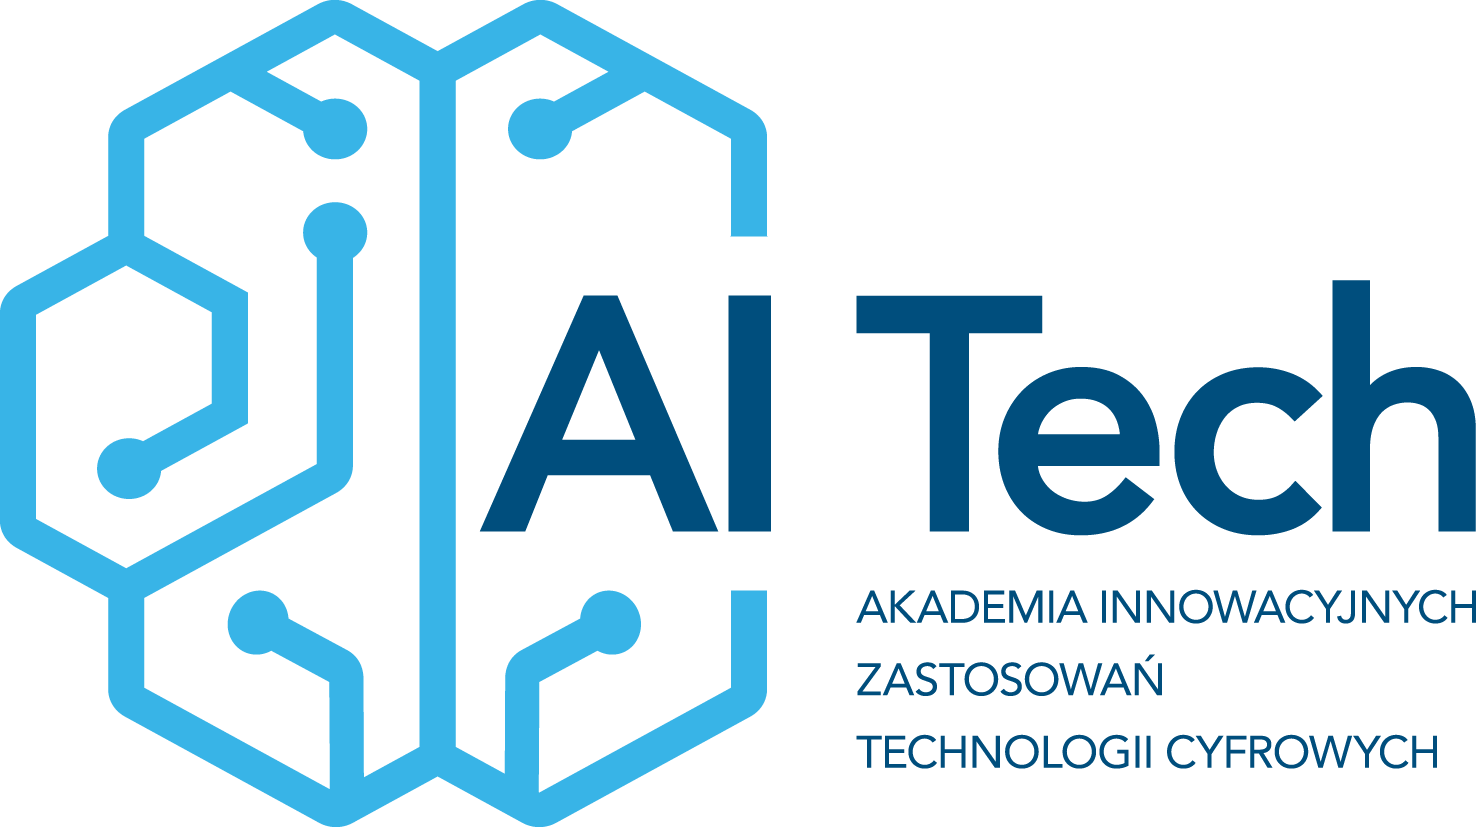
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>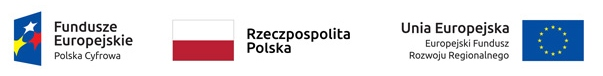</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Tomasz Pawłowski**




# ML in big scale - LAB 10



Stochastic Gradient Descent
A short introduction to SGD is available at [link](https://spark.apache.org/docs/latest/mllib-optimization.html#stochastic-gradient-descent-sgd)

There exist
* full batch (full training datasetis used during each iteration)
* mini batch (constant fraction of training dataset, selected randomly before each step is used in each iteration)
* mirrored (multiple mini-batches are performed in parallel and the change in weights is averaged)

Note: 
During this lab we will implement the SGD algorithm. There exist a mllib implementation ready to use: [LinearRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html#pyspark.ml.regression.LinearRegression). 





## Pyspark installation

In [1]:
!pip install pyspark --quiet
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

from pyspark.sql import SparkSession
spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("mlibs") \
                    .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext

## California housing (1990) dataset

See [link](https://developers.google.com/machine-learning/crash-course/california-housing-data-description?hl=en). For description of the dataset. Data splitted into train and test files in available in:
```
sample_data/california_housing_train.csv
sample_data/california_housing_test.csv
```

### Example 1. Loading data do RDD

In [2]:
from pyspark import RDD
from typing import TypeVar, Iterable, List, Tuple

T = TypeVar('T')

def drop_header(idx: int, iter: Iterable[T]) -> Iterable[T]:
  if idx == 0:
    next(iter)
  return iter

def parse_lines(line: str) -> List[float]:
  return [float(x) for x in line.split(",")]

TRAIN_RAW = sc.textFile('sample_data/california_housing_train.csv') \
    .mapPartitionsWithIndex(drop_header) \
    .map(parse_lines) \
    .cache()

# Note: alternatively you can use built in csv parser: spark.read.csv("sample_data/california_housing_train.csv", header=True).rdd

print(f"train count: {TRAIN_RAW.count()}")
print(TRAIN_RAW.take(10))
FEATURE_LEN = len(TRAIN_RAW.first()) - 1
print(f"no of features {FEATURE_LEN}")

TEST_RAW = sc.textFile('sample_data/california_housing_test.csv') \
    .mapPartitionsWithIndex(drop_header) \
    .map(parse_lines) \
    .cache()

print(f"test count: {TEST_RAW.count()}")
print(TEST_RAW.take(10))

train count: 17000
[[-114.31, 34.19, 15.0, 5612.0, 1283.0, 1015.0, 472.0, 1.4936, 66900.0], [-114.47, 34.4, 19.0, 7650.0, 1901.0, 1129.0, 463.0, 1.82, 80100.0], [-114.56, 33.69, 17.0, 720.0, 174.0, 333.0, 117.0, 1.6509, 85700.0], [-114.57, 33.64, 14.0, 1501.0, 337.0, 515.0, 226.0, 3.1917, 73400.0], [-114.57, 33.57, 20.0, 1454.0, 326.0, 624.0, 262.0, 1.925, 65500.0], [-114.58, 33.63, 29.0, 1387.0, 236.0, 671.0, 239.0, 3.3438, 74000.0], [-114.58, 33.61, 25.0, 2907.0, 680.0, 1841.0, 633.0, 2.6768, 82400.0], [-114.59, 34.83, 41.0, 812.0, 168.0, 375.0, 158.0, 1.7083, 48500.0], [-114.59, 33.61, 34.0, 4789.0, 1175.0, 3134.0, 1056.0, 2.1782, 58400.0], [-114.6, 34.83, 46.0, 1497.0, 309.0, 787.0, 271.0, 2.1908, 48100.0]]
no of features 8
test count: 3000
[[-122.05, 37.37, 27.0, 3885.0, 661.0, 1537.0, 606.0, 6.6085, 344700.0], [-118.3, 34.26, 43.0, 1510.0, 310.0, 809.0, 277.0, 3.599, 176500.0], [-117.81, 33.78, 27.0, 3589.0, 507.0, 1484.0, 495.0, 5.7934, 270500.0], [-118.36, 33.82, 28.0, 67.0, 15

## Exercise 1: Feature scaling

Scale features of the train data uniformly to ranges $[0,1]$

Note: use `sc.broadcast` to broadcast min_max variable.

Note2: If data is loaded as `Vector-s` or `Row-s` you can utilize the [StandardScaler](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html) class.

In [3]:
import sys
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

def get_min_max(x: RDD[List[float]]) -> List[Tuple[float, float]]:
  #put your code here
  # get the number of features
  num_features = len(x.first()) - 1
  
  # initialize the result list with (sys.float_info.max, -sys.float_info.max) for each feature
  result = [(sys.float_info.max, -sys.float_info.max) for i in range(num_features)]
  
  # use reduce() to update the result list with the minimum and maximum values for each feature
  for row in x.collect():
      for i in range(num_features):
          result[i] = (min(result[i][0], row[i]), max(result[i][1], row[i]))
  
  return result

  

def scale_features(x: RDD[List[float]], min_max: List[Tuple[float, float]]) -> RDD[List[float]]:
  #put your code here
  num_features = len(x.first()) - 1
  rdds = x.map(lambda row: [ (row[i] - min_max[i][0]) / (min_max[i][1] - min_max[i][0]) for i in range(num_features)])
  return rdds


min_max = get_min_max(TRAIN_RAW)
print(min_max)
TRAIN = scale_features(TRAIN_RAW, min_max).cache()
TEST = scale_features(TEST_RAW, min_max).cache()

print(TRAIN.take(10))
print(TEST.take(10))

[(-124.35, -114.31), (32.54, 41.95), (1.0, 52.0), (2.0, 37937.0), (1.0, 6445.0), (3.0, 35682.0), (1.0, 6082.0), (0.4999, 15.0001)]
[[1.0, 0.1753453772582357, 0.27450980392156865, 0.14788453934361406, 0.1989447548106766, 0.028364023655371506, 0.07745436605821411, 0.06853008924014842], [0.9840637450199207, 0.19766206163655672, 0.35294117647058826, 0.20160801370765782, 0.2948479205462446, 0.03155918047030466, 0.07597434632461766, 0.0910401235845023], [0.9750996015936255, 0.12221041445270968, 0.3137254901960784, 0.01892711216554633, 0.026846679081315952, 0.009249138148490708, 0.019075809899687553, 0.07937821547289003], [0.9741035856573714, 0.11689691817215739, 0.2549019607843137, 0.03951495979965731, 0.0521415270018622, 0.01435017797584013, 0.0370004933399112, 0.18563881877491345], [0.9741035856573714, 0.1094580233793837, 0.37254901960784315, 0.038275998418347175, 0.05043451272501552, 0.01740519633397797, 0.04292057227429699, 0.09828140301513083], [0.9731075697211159, 0.11583421891604707, 

## Exercise 2: Loss function

$L(W, x) = \frac{1}{2}(W^{T} x[:-1] - x[-1])^2$

For a given vector of weights $W$ calculate the loss value

In [4]:
def L(W: List[float], x: List[float]) -> float:
  # put your code here 
  return (0.5 * (sum([w * xi for w, xi in zip(W, x[:-1])]) - x[-1])**2)

L([1,2,3], [1,2,3,16])

2.0

In [5]:
import random 
W = [random.uniform(0.0, 1.0) for i in range(FEATURE_LEN)]
print(W)

[0.007127072973347692, 0.5238291546036544, 0.13792503555407365, 0.007384737012247844, 0.3738720069804973, 0.6633041759201355, 0.13420166944671552, 0.04052076902905344]


## Exercise 3: single step of SGD

Calculate updated weights using the following formula:

$w_i := w_i − \lambda\frac{∂L(W, x_j)}{∂w_i}$

$w[i] := w[i] - \lambda(𝑊^T𝑥[:−1]−𝑥[−1])x[i]$

In [6]:
def step(l: float, W: List[float], x: List[float]) -> List[float]:
  # put your code here
  diff = sum([w * xi for w, xi in zip(W, x[:-1])]) - x[-1]
  return [w - (l * diff * xi) for w, xi in zip(W, x)]

print(step(0.01, W, TRAIN.first()))

[0.0053971707464491, 0.523525824245059, 0.13745016043296424, 0.007128911218313453, 0.3735278520061205, 0.6632551089324502, 0.1340676809663884, 0.040402218675067346]


## Exercise 4: Total loss of dataset

Given a vector of weights and a RDD calculate the total loss value of the dataset.

$ L(W, X) =  \sum_{x \in X} L(W, x) $ 

Note: broadcast weights list

In [7]:
def total_loss(W: List[float], x: RDD[List[float]]) -> float:
  # put your code here    
  W_bc = sc.broadcast(W)
  return x.map(lambda row: L(W_bc.value, row)).sum()

print(total_loss(W, TRAIN))
print(total_loss(step(0.01, W, TRAIN.first()), TRAIN))

373.67913595629193
372.27385409187764


## Exercise 5: One iteration of full batch SGD

$w[j] := w[j] - \frac{\lambda}{m} \sum_i^m(𝑊^T𝑥_i[:−1]−𝑥_i[−1])x_i[j]$

In [8]:
def full_batch_step(l: float, W: List[float], x: RDD[List[float]]) -> List[float]:
  # put your code here 
  W_bc = sc.broadcast(W)
  gradient = x.map(lambda row: step(l, W_bc.value, row)).reduce(lambda x, y: [x[i] + y[i] for i in range(len(x))])
  n = x.count()
  return [W[i] - l * gradient[i] / n for i in range(len(W))]

print(total_loss(W, TRAIN))
print(full_batch_step(0.01, W, TRAIN))
print(total_loss(full_batch_step(0.2, W, TRAIN), TRAIN))

373.67913595629193
[0.007057771882869944, 0.518596491268052, 0.13655126667352158, 0.007311525256941, 0.37013423000602486, 0.656671566601831, 0.13286056100303717, 0.0401156494241609]
263.05988023587565


## Exercise 6: One iteration of mini-batch SGD

Use either [pyspark.RDD.sample](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.sample.html) or sample each partition independently.

In [9]:
import random

# p - probability of sampling a row
def mini_batch_step(l: float, W: List[float], x: RDD[List[float]], p: float) -> List[float]:
  # put your code here
  W_bc = sc.broadcast(W)
  mini_batch = x.filter(lambda row: random.uniform(0, 1) < p).map(lambda row: step(l, W_bc.value, row)).cache()
  n = mini_batch.count()
  gradient = mini_batch.reduce(lambda x, y: [x[i] + y[i] for i in range(len(x))])
  return [W[i] - l * gradient[i] / n for i in range(len(W))]

print(total_loss(W, TRAIN))
print(mini_batch_step(0.01, W, TRAIN, 0.2))
print(total_loss(mini_batch_step(0.2, W, TRAIN, 0.2), TRAIN))

373.67913595629193
[0.0070575209621083984, 0.5185962467132098, 0.1365508117917849, 0.007311465676319353, 0.37013417165469464, 0.656671522045704, 0.13286049937277478, 0.040115417961665366]
263.07428792732367


## Homework 1: Mirrored SGD

Run $k$ mini-batches in parallel and change the weights by the average of the computed changes.



In [13]:
def mirrored_step(l: float, W: List[float], x: RDD[List[float]], p: float, k: int) -> List[float]:
  batches = sc.emptyRDD()
  batches = batches.union(x.sample(withReplacement=True, fraction=p*k))
  return full_batch_step(l, W, batches)

print(total_loss(W, TRAIN))
print(mirrored_step(0.01, W, TRAIN, 0.2, 1))
print(total_loss(mirrored_step(0.2, W, TRAIN, 0.2, 2), TRAIN))

373.67913595629193
[0.007057774020432176, 0.5185967086235151, 0.13655141973235602, 0.007311531922528291, 0.3701342424028811, 0.656671567436195, 0.13286057067976856, 0.04011569971074973]
263.06786239555606


## Homework 2: convergence comparison

Compare the changes of loss value of test dataset in time between full batch, mini-batch with 20% of values and mirrored SGD running 5 mini-batches of 20% of values.


In [17]:
import time
import matplotlib.pyplot as plt

def measure_time():
  return time.perf_counter()

def conduct_experiment(initial_weights, training_data, testing_data, approach, learning_rate=0.2, batch_proportion=0.2, num_batches=5, num_epochs=20):
  weights = initial_weights
  start = measure_time()
  elapsed_times = [0]
  error_values = [total_loss(weights, testing_data)]
  for i in range(num_epochs):
    if approach == 'full':
      weights = full_batch_step(learning_rate, weights, training_data)
    elif approach == 'minibatch':
      weights = mini_batch_step(learning_rate, weights, training_data, batch_proportion)
    else:
      weights = mirrored_step(learning_rate, weights, training_data, batch_proportion, num_batches)
    error = total_loss(weights, testing_data)
    elapsed_times.append(measure_time() - start)
    error_values.append(error)
  return elapsed_times, error_values


FEATURE_LENGTH = 8
weights = [random.uniform(0.0, 1.0) for i in range(FEATURE_LENGTH)]
time_results = {}
error_results = {}
for approach in 'full', 'minibatch', 'mirrored':
  elapsed_times, error_values = conduct_experiment(weights, TRAIN, TEST, approach, learning_rate=0.2, batch_proportion=0.2, num_batches=5, num_epochs=50)
  time_results[approach] = elapsed_times
  error_results[approach] = error_values

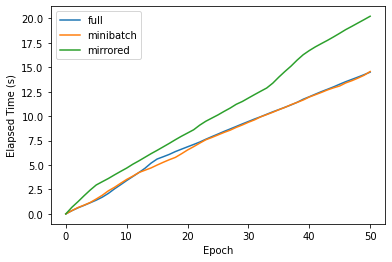

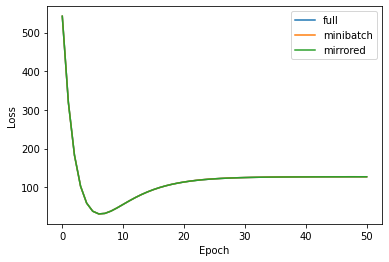

In [18]:
# Plot elapsed time
for approach in time_results:
  plt.plot(time_results[approach], label=approach)

plt.xlabel('Epoch')
plt.ylabel('Elapsed Time (s)')
plt.legend()
plt.show()

# Plot loss
for approach in error_results:
  plt.plot(error_results[approach], label=approach)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<center>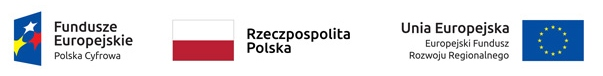</center>